In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report 
import pandas as pd
import graphviz 
from sklearn import tree

In [39]:
clustering_df = pd.read_csv("nps_df_clustering.csv") 

In [40]:
clustering_df.describe()

,age,salary,num_reclama_sac,nota
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,37.342662,4998.207881,2.656800,6.826467
std,13.572768,501.630488,2.434737,2.866826
min,-32.022140,3009.342109,0.000000,0.000000
25%,32.396932,4659.446258,1.000000,6.000000
50%,38.483503,4998.116042,2.000000,8.000000
75%,48.452143,5334.283367,4.000000,9.000000
max,79.865479,7167.653254,9.000000,10.000000


#### Objetivo
- Criar uma árvore de decisão visando descrever o comportamento da base, e não realizar uma predição:
 - Não precisamos de um split de train e test, a capacidade de separação do modelo é dada pela própria métrica da árvore (gini)
 - Podemos buscar um fitting mais ajustado aos dados, porém cuidado com overfitting
 - Como nosso foco são as folhas, vamos garantir que cada uma tenha um percentual da base

In [41]:
dt = DecisionTreeClassifier(min_samples_leaf = int(clustering_df.shape[0]*0.1))
dt.fit(clustering_df.drop("nota", axis=1), 
        clustering_df.nota)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

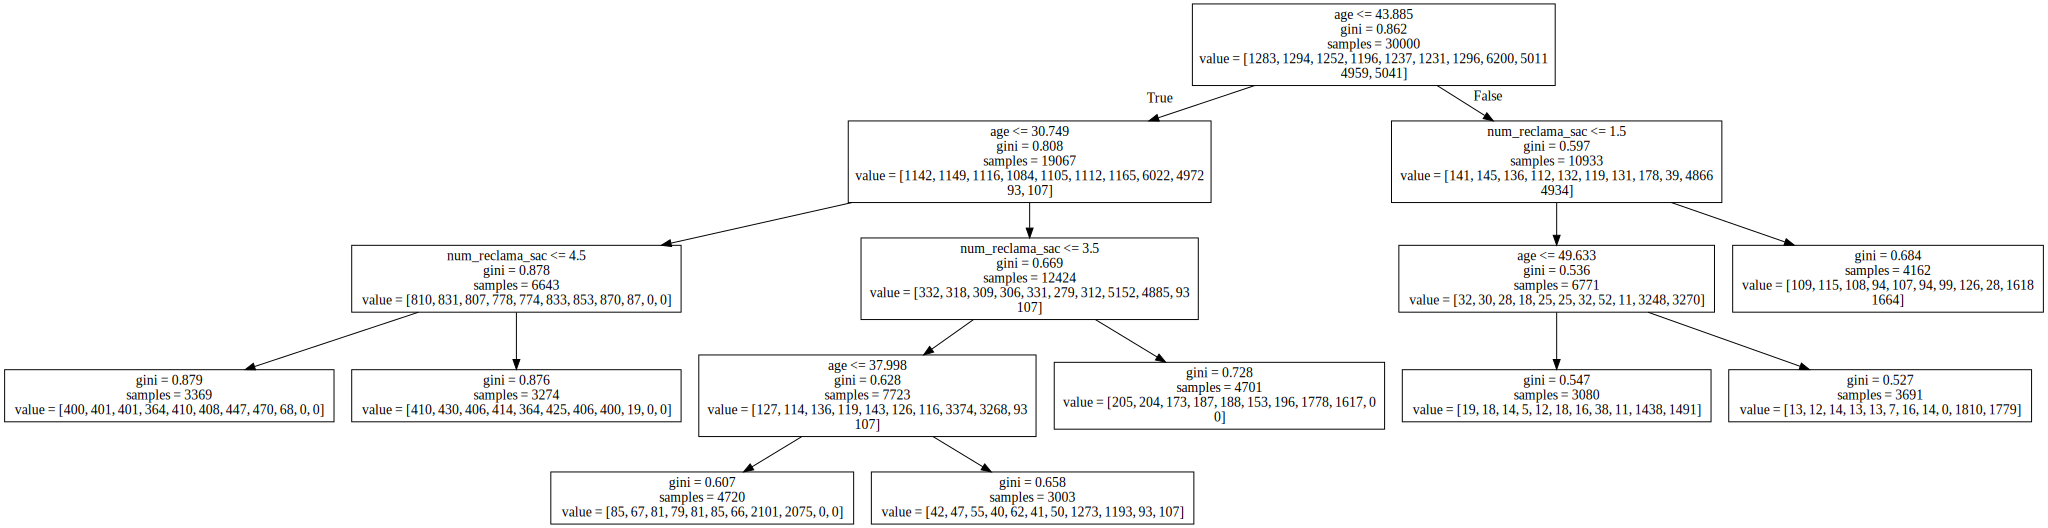

In [42]:
#Vamos agora observar, visualmente, nossa árvore criada, onde cada folha é um grupo:
dot_data = tree.export_graphviz(dt, out_file=None,feature_names=clustering_df.drop(["nota"],axis=1).columns) 
graph = graphviz.Source(dot_data)
graph

In [43]:
#Vamos descobrir em qual folha cada amostra pertence
clustering_df["tree_node"] = dt.apply(clustering_df.drop("nota", axis=1)) 

In [44]:
#Utilizamos as folhas para criar nossas descritivas:
clustering_df["tree_node"].value_counts()

7     4720
9     4701
14    4162
13    3691
3     3369
4     3274
12    3080
8     3003
Name: tree_node, dtype: int64

In [45]:
clustering_df["nota"][clustering_df.nota > 8].count()

10000

In [51]:
def get_nps_score(data):
    promotor = data["nota"][data.nota > 8].count()
    detrator = data["nota"][data.nota < 7].count()
    total = data["nota"].count()
    
    return (promotor-detrator)/total

In [62]:
calculo_nps = clustering_df.groupby(["tree_node"]).apply(get_nps_score)

In [69]:
calculo_nps

tree_node
3    -0.840309
4    -0.872022
7    -0.115254
8    -0.045621
9    -0.277813
12    0.917857
13    0.948523
14    0.614128
dtype: float64

In [73]:
nps_per_leaf_df = pd.DataFrame({"tree_node":calculo_nps.index,
              "nps":calculo_nps.values
             })

In [81]:
clustering_df_com_nps = pd.merge(clustering_df,nps_per_leaf_df, on="tree_node")

In [83]:
clustering_df_com_nps.groupby(["tree_node"]).agg({"age": ["mean"],
                                         "salary": ["mean"],
                                         "num_reclama_sac":["mean"],
                                         "nps":["max"] })

,age,salary,num_reclama_sac,nps
,mean,mean,mean,max
tree_node,,,,
3,16.975608,4982.435802,1.990205,-0.840309
4,16.551751,5007.625725,6.931582,-0.872022
7,35.228172,5002.738962,1.508898,-0.115254
8,40.213489,4999.172664,1.470196,-0.045621
9,36.964776,4997.257075,5.106360,-0.277813
12,47.536600,5009.613536,0.502922,0.917857
13,52.287366,4987.480218,0.509618,0.948523
14,50.140250,4999.878780,2.722970,0.614128
